In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import src.tera_project_preprocess as preprocess
import src.tera_project_charts as charts


from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers.legacy import Adam

# Carregamento dos dados

In [2]:
#series = pd.read_csv('/home/augusto/Tera/Projeto/data/milho-cepea_RS.csv', index_col = 0)
# df.head()

# Importa e transforma o date em tipo datetime e define como index
data_path = '/home/augusto/Tera/Projeto/data/milho-cepea_RS.csv'
date_column = 'date'
series = preprocess.load_timeseries_csv(data_path,date_column)
# series.head()

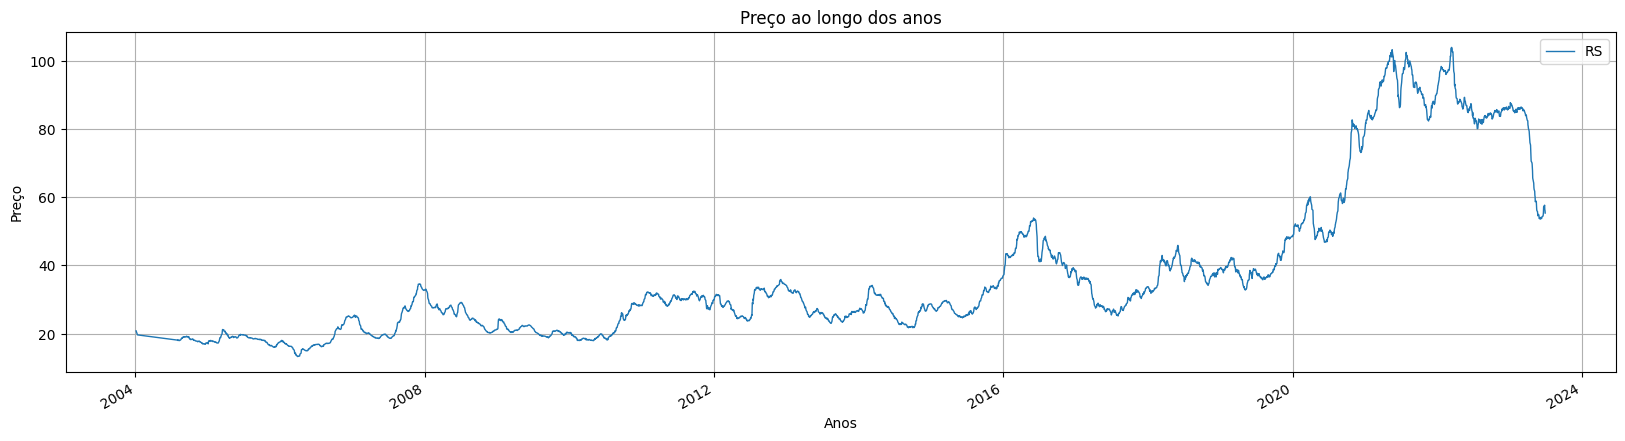

In [3]:
# series.plot(figsize = (15,5))
charts.plot_series_line(data=series, title_value='Preço ao longo dos anos', xlabel_value='Anos',ylabel_value='Preço')

# Escalonamento dos dados

In [4]:
def data_scaler(series_value):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(series_value.values.reshape(-1, 1))
    scaled_data = [scaled_data[i][0] for i in range(len(scaled_data))]
    return scaler, scaled_data

In [5]:
scaler, scaled_data = data_scaler(series['RS'])

# Sequenciamento dos dados para LSTM

In [6]:
def Sequential_Input_LSTM(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

In [7]:
# Número de dados de entrada usados para o forecast dos valores futuros da série temporal

sequence_length = 10
X, y = Sequential_Input_LSTM(scaled_data, sequence_length)


# Criação dos datasets de treino, teste e avaliação

In [8]:
train_len = int(len(X) * 0.7)
val_len = int(len(X) * 0.9)

# Training data
X_train, y_train = X[:train_len], y[:train_len]

# Validation data
X_val, y_val = X[train_len:val_len], y[train_len:val_len]

# Test data
X_test, y_test = X[val_len:], y[val_len:]

# Definição e treino da LSTM

In [9]:
# Quantidades de variáveis de entrada (preço em reais)
n_features = 1

model = Sequential()

model.add(InputLayer((sequence_length, n_features)))
model.add(LSTM(100, return_sequences = True))
model.add(LSTM(100, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

2023-09-29 22:15:46.073797: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-29 22:15:46.093947: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-29 22:15:46.094009: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-29 22:15:46.097591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-29 22:15:46.097680: I tensorflow/compile

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 10, 100)           80400     
                                                                 
 lstm_2 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 8)                 408       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 151817 (593.04 KB)
Trainable params: 151817 (593.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

model.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.0001), metrics = RootMeanSquaredError())

In [12]:
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 200, callbacks = [early_stop])

Epoch 1/200


2023-09-29 22:15:51.145410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-29 22:15:51.327529: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


103/103 [==============================] - 6s 20ms/step - loss: 0.0073 - root_mean_squared_error: 0.0851 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1134
Epoch 2/200
103/103 [==============================] - 1s 14ms/step - loss: 3.2830e-04 - root_mean_squared_error: 0.0181 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0465
Epoch 3/200
103/103 [==============================] - 2s 15ms/step - loss: 1.6612e-04 - root_mean_squared_error: 0.0129 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0428
Epoch 4/200
103/103 [==============================] - 1s 13ms/step - loss: 1.5919e-04 - root_mean_squared_error: 0.0126 - val_loss: 8.4187e-04 - val_root_mean_squared_error: 0.0290
Epoch 5/200
103/103 [==============================] - 1s 13ms/step - loss: 1.6144e-04 - root_mean_squared_error: 0.0127 - val_loss: 7.4682e-04 - val_root_mean_squared_error: 0.0273
Epoch 6/200
103/103 [==============================] - 1s 13ms/step - loss: 1.5592e-04 - root_mean_squared_error: 0.01

# Métricas de cada Epoch

In [13]:
losses_model = pd.DataFrame(model.history.history)
losses_model

,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
0,0.007250,0.085148,0.012867,0.113433
1,0.000328,0.018119,0.002164,0.046520
2,0.000166,0.012889,0.001835,0.042836
3,0.000159,0.012617,0.000842,0.029015
4,0.000161,0.012706,0.000747,0.027328
5,0.000156,0.012487,0.000655,0.025599
6,0.000156,0.012475,0.000621,0.024930
7,0.000151,0.012276,0.000643,0.025367
8,0.000151,0.012275,0.000725,0.026922


In [14]:
def losses_model_plot(losses_model):
    losses_model.plot(figsize = (15,6))
    plt.title('Model losses')
    plt.xlabel('Epochs')
    plt.ylabel('Values')

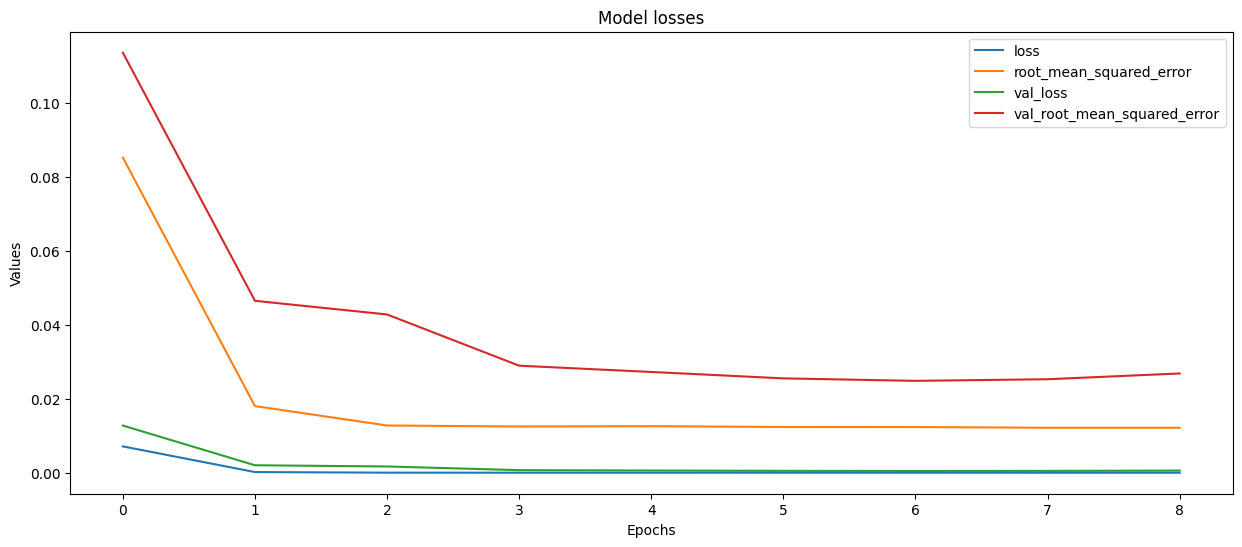

In [15]:
losses_model_plot(losses_model)

# Métricas internas do modelo

In [16]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

loss: 0.08%
root_mean_squared_error: 2.76%


# Test model

In [17]:
test_predictions = model.predict(X_test)

15/15 [==============================] - 1s 5ms/step


In [18]:
# Transformando y_test em bidimensional
# para usar o inverse scalar
y_test = [[x] for x in y_test]

In [19]:
#Inverse scaler
test_predictions = scaler.inverse_transform(test_predictions).flatten()
y_test = scaler.inverse_transform(y_test).flatten()

In [29]:
test_score = np.sqrt(mean_squared_error(y_test, test_predictions))

print(f'Train Score: {test_score:.2f} RMSE')

Train Score: 2.50 RMSE


In [20]:
test_predictions_df = pd.DataFrame({'Data_test':list(y_test), 'LSTM Prediction':list(test_predictions)})

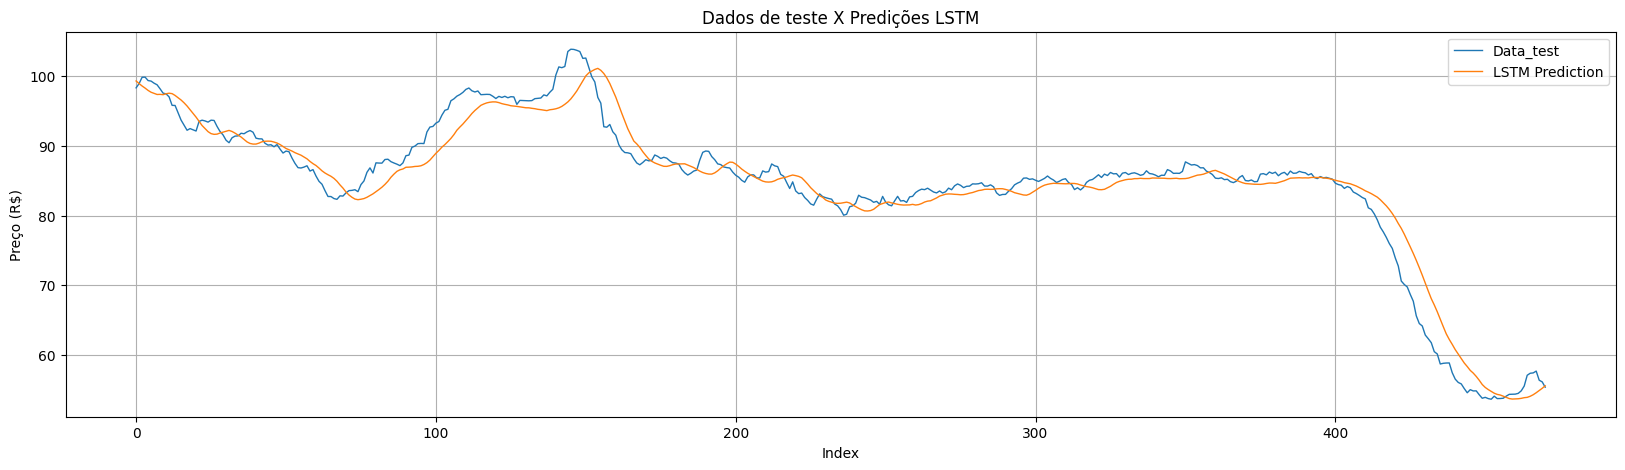

In [26]:
charts.plot_series_line(test_predictions_df, title_value='Dados de teste X Predições LSTM', xlabel_value='Index', ylabel_value='Preço (R$)')

In [30]:
save_model(model, f"LSTM_Models/lstm_{test_score:.2f}.h5")

/tmp/ipykernel_44236/809845933.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, f"LSTM_Models/lstm_{test_score:.2f}.h5")
